# 🏛️ Vesuvius Challenge - Surface Detection Baseline

### Simple 3D Segmentation Approach

This notebook demonstrates a **full 3D segmentation pipeline running entirely on GPU**, including data loading and augmentations. Key features:

- **GPU-Accelerated Augmentations**: Leveraging MONAI transforms to perform data augmentations directly on the GPU, significantly speeding up the training process by minimizing data transfers.
- **Faster I/O**: Utilizes pre-saved `.npy` and `.npz` volumes for both images and labels, which are much faster to load than `.tif` files, further enhancing data throughput.
- **Optimized Data Module**: A custom `SurfaceDataset3D` and `SurfaceDataModule` handle variable-sized 3D volumes efficiently, resizing them on the fly to `MODEL_INPUT_SIZE` during GPU-accelerated augmentation.
- **Robust Model Training**: Employs a MONAI UNet for 3D segmentation with PyTorch Lightning for a clean, reproducible training workflow, including metrics like Dice and IoU.
- **Simple Baseline**: This is a straightforward baseline implementation, offering substantial room for improvement through more advanced architectures, data augmentation strategies, loss functions, and ensemble methods.

### 📊 Data Structure

```
vesuvius-challenge-surface-detection/
├── train_images/       # 3D TIFF volumes
│   ├── 1004283650.tif
│   └── ...
├── train_labels/       # 3D mask annotations (same filenames)
│   ├── 1004283650.tif
│   └── ...
└── test_images/        # Test volumes (no labels)
    └── ...
```

In [1]:
!pip install --no-index --find-links="/kaggle/input/surface-detect-package-scraper" -q pytorch_lightning monai albumentations imagecodecs --no-deps # "numpy==1.26.4" "scipy==1.15.3"
!pip uninstall -q -y tensorflow  # preventing AttributeError

In [2]:
import random
import random
import numpy as np
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [3]:
import os
import warnings
from pathlib import Path
from typing import Tuple, Optional, Dict, List, Callable

import imagecodecs
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

# Paths
DATA_DIR = Path("/kaggle/input/vesuvius-challenge-surface-detection")
CHECKPOINT_DIR = "/kaggle/input/vesuvius-surface-detection-3d-checkpoints/pytorch/default/0"
# TRAIN_IMAGES_DIR = DATA_DIR / "train_images"
# TRAIN_LABELS_DIR = DATA_DIR / "train_labels"
TRAIN_IMAGES_DIR = Path("/kaggle/input/vesuvius-surface-npz/train_images")
TRAIN_LABELS_DIR = Path("/kaggle/input/vesuvius-surface-npz/train_labels")
TEST_IMAGES_DIR = DATA_DIR / "test_images"
OUTPUT_DIR = Path(".")

In [4]:
# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Model architecture
# MODEL_INPUT_SIZE = (224, 224, 224)  # (depth, height, width) - resize volumes to this
MODEL_INPUT_SIZE = (160, 160, 160)  # (depth, height, width) - resize volumes to this
IN_CHANNELS = 1  # grayscale
OUT_CHANNELS = 2  # background + papyrus (ignore class 2)

# Training
BATCH_SIZE = 2
NUM_WORKERS = 4
MAX_EPOCHS = 100
LEARNING_RATE = 1e-3

In [5]:
DEVICE

'cuda'

In [6]:
MAX_EPOCHS

100

## 📊 Dataset

In [7]:
import tifffile
import numpy as np

class SurfaceDataset3D(Dataset):
    """3D Surface Detection Dataset.

    Updated to support volume-based loading.
    Optimized for faster Torch conversion.
    Supports .tif, .npy, .npz formats.
    """

    def __init__(
        self,
        images_dir: Path,
        labels_dir: Optional[Path],
        volume_files: Optional[List[str]] = None,
        volume_shape: Tuple[int, int, int] = (64, 64, 64), # Kept for compatibility, unused
    ):
        super().__init__()
        self.images_dir = images_dir
        # Ensure labels_dir is a Path to prevent errors in _load_from_raw
        self.labels_dir = labels_dir if labels_dir is not None else Path("__no_label__")
        self.volume_files = volume_files
        self.volume_shape = volume_shape

        # Validate and populate volume_files
        self._prepare_volume_files()

    def _prepare_volume_files(self):
        """Validate and index provided volumes, updating self.volume_files."""
        # Determine source of files
        if self.volume_files is None:
             print(f"No volume files specified. Scanning {self.images_dir}...")
             # Priority: npy > npz > tif
             extensions = [".npy", ".npz", ".tif"]
             self.volume_files = []
             # TODO: Add check for duplicates if multiple formats exist for the same volume.
             # Currently assuming each volume appears only once across these formats.
             for ext in extensions:
                 # glob returns full paths, we just want filenames
                 files = sorted([p.name for p in self.images_dir.glob(f"*{ext}")])
                 self.volume_files.extend(files)

        print(f"Indexing volumes...")
        valid_files = []
        for filename in self.volume_files:
            image_path = self.images_dir / filename
            if not image_path.exists():
                print(f"Warning: {image_path} not found, skipping.")
                continue
            valid_files.append(filename)

        self.volume_files = valid_files
        print(f"Found {len(self.volume_files)} volumes.")

    def __len__(self) -> int:
        return len(self.volume_files)

    def __getitem__(self, idx: int):
        filename = self.volume_files[idx]
        # Load raw data -> (D, H, W)
        image, mask = self._load_from_raw(filename)
        # Optimization: Convert directly to Tensor to avoid intermediate numpy float64 copies
        # 1. Convert raw uint8/uint16 -> Tensor
        # 2. Cast to float16
        # 3. Scale
        # 4. Add channel dim
        image_t = torch.from_numpy(image).half().div_(255.0).unsqueeze(0)

        # Handle Mask
        if mask is not None:
             mask_t = torch.from_numpy(mask).long().unsqueeze(0)
        else:
             # Return dummy mask for test set (class 2 is ignored in loss)
             mask_t = torch.full_like(image_t, 2, dtype=torch.long)

        # Return fragment ID (filename without extension) for prediction grouping
        frag_id = Path(filename).stem
        return image_t, mask_t, frag_id

    def _load_file(self, path: Path) -> np.ndarray:
        """Helper to load generic file formats."""
        if path.suffix == ".npy":
            return np.load(str(path))
        if path.suffix == ".npz":
            data = np.load(str(path))
            # Return the first array found in the archive
            return data[list(data.files)[0]]
        # Original dataset format
        return tifffile.imread(str(path))

    def _load_from_raw(
        self,
        volume_file: str,
    ) -> Tuple[np.ndarray, Optional[np.ndarray]]:
        """Helper to load image and mask from raw TIFF files."""
        # Load from disk
        image_path = self.images_dir / volume_file
        image_volume = self._load_file(image_path)

        label_volume = None
        label_path = self.labels_dir / volume_file
        if label_path.exists():
            label_volume = self._load_file(label_path)

        return image_volume, label_volume

## 📦 DataModule

In [8]:
import random
from torch.utils.data import DataLoader
from monai import transforms as MT

def custom_collate(batch):
    """Custom collate to handle variable size 3D volumes.
    Returns a list of items instead of stacking them, allowing GPU resizing later.
    """
    return batch

class SurfaceDataModule(pl.LightningDataModule):
    """Lightning DataModule for Surface Detection.

    Handles all data loading, splitting, and dataloader creation.
    Updated to use MONAI 3D augmentations on GPU with dynamic resizing.
    """

    def __init__(
        self,
        train_images_dir: Path,
        train_labels_dir: Path,
        volume_shape: Tuple[int, int, int] = (64, 64, 64),
        val_split: float = 0.2,
        batch_size: int = BATCH_SIZE,
        num_workers: int = NUM_WORKERS
    ):
        super().__init__()
        self.train_images_dir = train_images_dir
        self.train_labels_dir = train_labels_dir
        self.volume_shape = volume_shape
        self.val_split = val_split
        self.batch_size = batch_size
        self.num_workers = num_workers

        # Will be set in setup()
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None

        # Define GPU-based augmentations using MONAI
        # 1. Resize to target shape (trilinear for image, nearest for label)
        # 2. Apply Augmentations
        self.gpu_augments = MT.Compose([
            MT.Resized(keys=["image", "label"], spatial_size=self.volume_shape, mode=["trilinear", "nearest"]),
            MT.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
            MT.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
            MT.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
            MT.RandRotated(keys=["image", "label"], range_x=0.1, range_y=0.1, range_z=0.1, prob=0.3, keep_size=True, mode=["bilinear", "nearest"]),
            MT.RandShiftIntensityd(keys=["image"], offsets=0.1, prob=0.5),
            MT.RandGaussianNoised(keys=["image"], prob=0.3, mean=0.0, std=0.01),
        ])
        # Validation transforms: Just Resize (for image AND label)
        self.val_augments = MT.Compose([
            MT.Resized(keys=["image", "label"], spatial_size=self.volume_shape, mode=["trilinear", "nearest"])
        ])
        # Validation transforms for Image ONLY (for test set where labels are None)
        self.val_image_augments = MT.Compose([
            MT.Resized(keys=["image"], spatial_size=self.volume_shape, mode=["trilinear"])
        ])

    def setup(self, stage: Optional[str] = None):
        """Setup datasets for different stages."""
        print(f"\nSetting up training data...")

        # Get all available training files (scanning for npy, npz, tif)
        extensions = [".npy", ".npz", ".tif"]
        all_files = []
        for ext in extensions:
             files = sorted([f.name for f in self.train_images_dir.glob(f"*{ext}")])
             all_files.extend(files)

        if not all_files:
            raise RuntimeError(f"No volume files found in {self.train_images_dir}. Check your data path.")

        # Shuffle for random split (deterministic with seed)
        random.seed(42)
        random.shuffle(all_files)
        # Split into train/val
        split_idx = int(len(all_files) * (1 - self.val_split))
        train_files = all_files[:split_idx]
        val_files = all_files[split_idx:]

        print(f"Total files: {len(all_files)}")
        print(f"Train files: {len(train_files)}")
        print(f"Val files: {len(val_files)}")

        # Create train dataset
        self.train_dataset = SurfaceDataset3D(
            images_dir=self.train_images_dir,
            labels_dir=self.train_labels_dir,
            volume_files=train_files,
            volume_shape=self.volume_shape
        )
        # Create validation dataset
        self.val_dataset = SurfaceDataset3D(
            images_dir=self.train_images_dir,
            labels_dir=self.train_labels_dir,
            volume_files=val_files,
            volume_shape=self.volume_shape
        )

    def train_dataloader(self) -> DataLoader:
        """Create train dataloader with custom collate for variable sizes."""
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=bool(self.num_workers > 0),
            collate_fn=custom_collate
        )

    def val_dataloader(self) -> DataLoader:
        """Create validation dataloader with custom collate for variable sizes."""
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=bool(self.num_workers > 0),
            collate_fn=custom_collate
        )

    def on_after_batch_transfer(self, batch, dataloader_idx):
        """Apply MONAI GPU-accelerated 3D augmentations to the batch."""
        # If custom_collate is used, batch is a list of tuples [(x, y, id), ...]
        if not isinstance(batch, list):
            return super().on_after_batch_transfer(batch, dataloader_idx)

        x_list, y_list, frag_ids = [], [], []
        # Determine device to ensure we process on GPU
        # self.trainer.strategy.root_device is reliable in Lightning
        device = self.trainer.strategy.root_device if self.trainer else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Select transform
        transforms = self.gpu_augments if self.trainer.training else self.val_augments

        for item in batch:
            x, y, frag_id = item
            # IMPORTANT: Explicitly move to GPU now.
            # This ensures the Resized and other transforms run on VRAM, avoiding CPU RAM spikes.
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            data = {"image": x, "label": y}
            # Apply transforms (Resize + Augments)
            data = transforms(data)

            x_list.append(data["image"])
            y_list.append(data["label"])
            frag_ids.append(frag_id)

        # Stack into tensors -> (B, C, D, H, W)
        return torch.stack(x_list), torch.stack(y_list), frag_ids

In [9]:
# Create DataModule
datamodule = SurfaceDataModule(
    train_images_dir=TRAIN_IMAGES_DIR,
    train_labels_dir=TRAIN_LABELS_DIR,
    volume_shape=MODEL_INPUT_SIZE,
)
datamodule.setup()


Setting up training data...
Total files: 786
Train files: 628
Val files: 158
Indexing volumes...
Found 628 volumes.
Indexing volumes...
Found 158 volumes.


Raw ID: 1927075549
Raw Image Shape: torch.Size([1, 320, 320, 320])
Resized Image Shape: (160, 160, 160)
Mask Shape: (160, 160, 160)
Image Range: 0.0 - 1.0


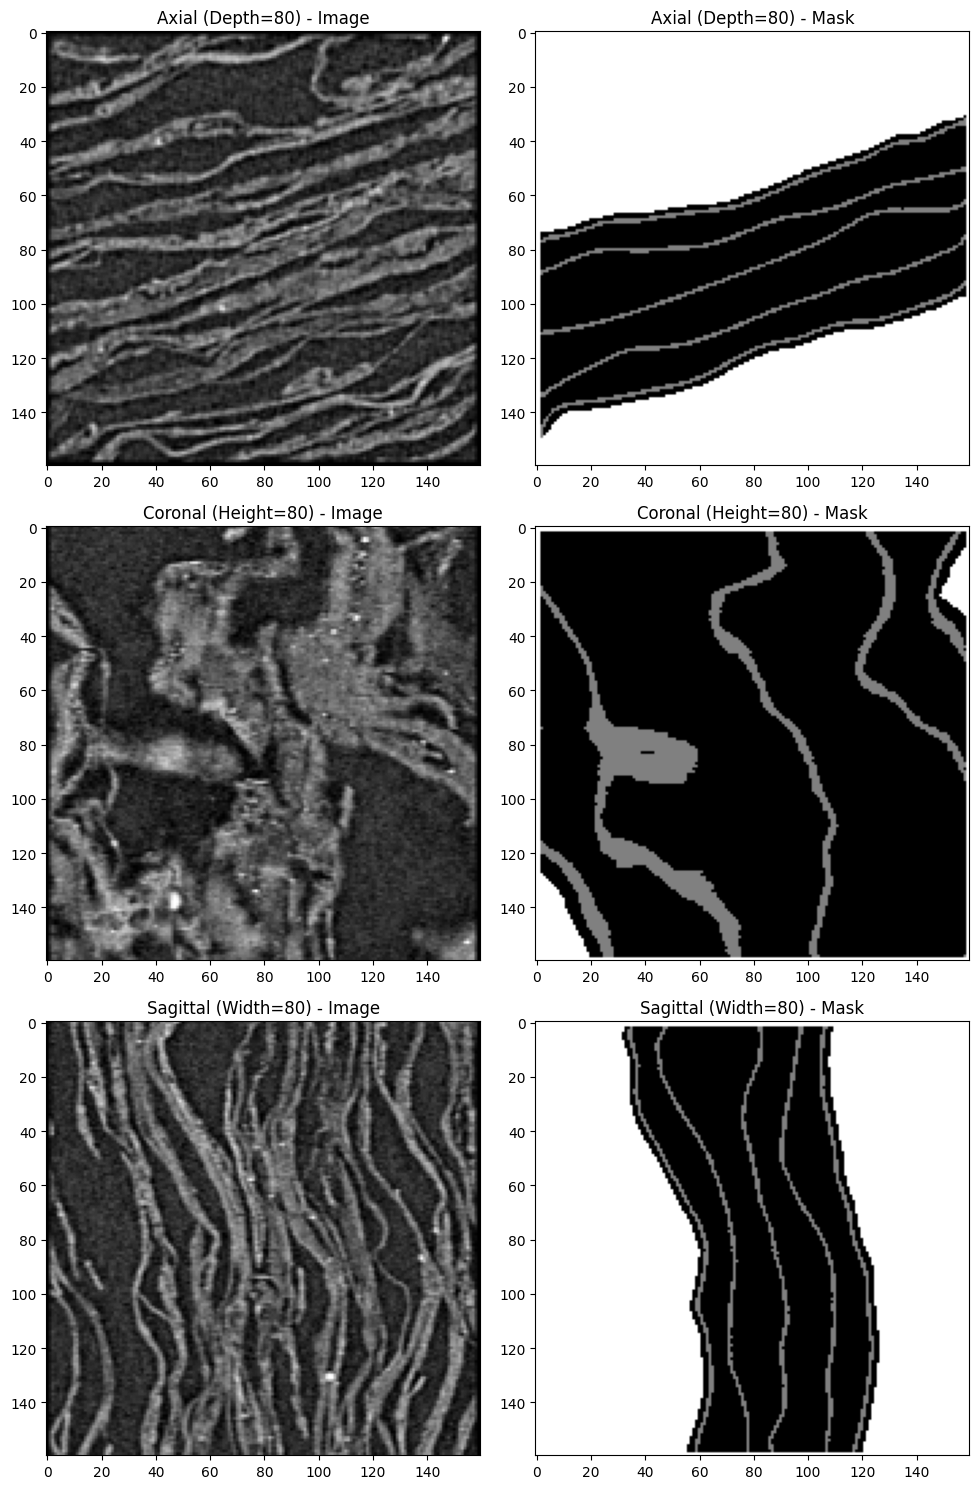

In [10]:
import matplotlib.pyplot as plt

# Get a batch
train_loader = datamodule.train_dataloader()
batch = next(iter(train_loader))

# With custom_collate, batch is a list: [(img, mask, id), ...]
# We extract the first sample
raw_img, raw_mask, frag_id = batch[0]

print(f"Raw ID: {frag_id}")
print(f"Raw Image Shape: {raw_img.shape}")

# Manually apply the validation transform (Resize) to visualize the model input
# We use val_augments which only contains Resized
# Construct dictionary as expected by MONAI transforms
data = {"image": raw_img, "label": raw_mask}
data_resized = datamodule.val_augments(data)

images = data_resized["image"]
masks = data_resized["label"]

# Select first channel
img = images[0].numpy()  # (D, H, W)
msk = masks[0].numpy()   # (D, H, W)

print(f"Resized Image Shape: {img.shape}")
print(f"Mask Shape: {msk.shape}")
print(f"Image Range: {img.min()} - {img.max()}")

# Calculate middle indices
d_mid = img.shape[0] // 2
h_mid = img.shape[1] // 2
w_mid = img.shape[2] // 2

# Setup plot: 3 Rows (Axes), 2 Cols (Image, Mask)
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

# Row 1: Z-axis (Depth/Axial)
axes[0, 0].imshow(img[d_mid, :, :], cmap='gray')
axes[0, 0].set_title(f'Axial (Depth={d_mid}) - Image')
axes[0, 1].imshow(msk[d_mid, :, :], cmap='gray')
axes[0, 1].set_title(f'Axial (Depth={d_mid}) - Mask')

# Row 2: Y-axis (Height/Coronal)
axes[1, 0].imshow(img[:, h_mid, :], cmap='gray')
axes[1, 0].set_title(f'Coronal (Height={h_mid}) - Image')
axes[1, 1].imshow(msk[:, h_mid, :], cmap='gray')
axes[1, 1].set_title(f'Coronal (Height={h_mid}) - Mask')

# Row 3: X-axis (Width/Sagittal)
axes[2, 0].imshow(img[:, :, w_mid], cmap='gray')
axes[2, 0].set_title(f'Sagittal (Width={w_mid}) - Image')
axes[2, 1].imshow(msk[:, :, w_mid], cmap='gray')
axes[2, 1].set_title(f'Sagittal (Width={w_mid}) - Mask')

plt.tight_layout()
plt.show()

## 🧠 Model

In [11]:
%%writefile surface_model.py

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
from typing import Tuple, Dict
from monai.losses import DiceCELoss, TverskyLoss


class SurfaceSegmentation3D(pl.LightningModule):
    """3D Surface Segmentation using a custom network.

    Key Design Choices:
    - **Loss**: Combined DiceCELoss + TverskyLoss to handle structural imbalance.
    - **Metrics**: Manual computation of Dice and IoU ignoring class 2.
    """

    def __init__(
        self,
        net: nn.Module,
        out_channels: int = 2,
        spatial_dims: int = 3,
        learning_rate: float = 1e-3,
        weight_decay: float = 1e-4,
        ignore_index_val: int = 2
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["net"])
        self.net_module = net
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.ignore_index_val = ignore_index_val

        # Loss function configuration
        # TverskyLoss with alpha=0.7 emphasizes minimizing False Negatives (Recall)
        self.criterion_tversky = TverskyLoss(
            softmax=True,
            to_onehot_y=False,
            include_background=True,
            alpha=0.7,
            beta=0.3
        )
        # DiceCELoss combines Dice Loss and Cross Entropy Loss
        self.criterion_dice_ce = DiceCELoss(
            softmax=True,
            to_onehot_y=False,
            include_background=True,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net_module(x)

    def _compute_loss(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """Compute loss excluding class 2 (unlabeled). Optimized for GPU."""
        # targets shape: (B, 1, D, H, W)
        mask = (targets != self.ignore_index_val)
        # Prepare targets for One-Hot Encoding (replace ignore index with 0 temporary)
        targets_sq = targets.squeeze(1)
        targets_clean = torch.where(mask.squeeze(1), targets_sq, torch.tensor(0, device=targets.device))
        # One-Hot Encode
        targets_onehot = torch.nn.functional.one_hot(
            targets_clean.long(),
            num_classes=self.hparams.out_channels
        ).float()
        if self.hparams.spatial_dims == 3:
            targets_onehot = targets_onehot.permute(0, 4, 1, 2, 3)
        else:
            targets_onehot = targets_onehot.permute(0, 3, 1, 2)
        # Mask One-Hot Targets
        targets_masked_ohe = targets_onehot * mask.half()

        # Compute both losses and sum them
        loss_tversky = self.criterion_tversky(logits, targets_masked_ohe)
        loss_dice_ce = self.criterion_dice_ce(logits, targets_masked_ohe)

        return loss_tversky + loss_dice_ce

    def _compute_metrics(self, preds_logits: torch.Tensor, targets_class_indices: torch.Tensor) -> dict:
        preds_proba = torch.softmax(preds_logits, dim=1)
        preds_hard = torch.argmax(preds_proba, dim=1, keepdim=True)
        valid_mask = (targets_class_indices != self.ignore_index_val).float() # (B, 1, D, H, W)
        num_classes = preds_logits.shape[1] # This will be 2 (background, foreground)
        dice_scores_per_class = []
        iou_scores_per_class = []

        for i in range(num_classes):
            pred_class_i = (preds_hard == i).float() # (B, 1, D, H, W)
            target_class_i = (targets_class_indices == i).float() # (B, 1, D, H, W)

            pred_class_i_valid = pred_class_i * valid_mask
            target_class_i_valid = target_class_i * valid_mask

            intersection = (pred_class_i_valid * target_class_i_valid).sum()
            union_sum_dice = pred_class_i_valid.sum() + target_class_i_valid.sum()
            union_sum_iou = pred_class_i_valid.sum() + target_class_i_valid.sum() - intersection
            dice = (2 * intersection + 1e-8) / (union_sum_dice + 1e-8)
            iou = (intersection + 1e-8) / (union_sum_iou + 1e-8)
            dice_scores_per_class.append(dice)
            iou_scores_per_class.append(iou)

        mean_dice = torch.mean(torch.stack(dice_scores_per_class))
        mean_iou = torch.mean(torch.stack(iou_scores_per_class))
        return {"dice": mean_dice, "iou": mean_iou}

    def training_step(self, batch: Tuple, batch_idx: int) -> torch.Tensor:
        inputs, targets, _ = batch
        logits = self(inputs)
        loss = self._compute_loss(logits, targets)

        metrics = self._compute_metrics(logits, targets)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_dice", metrics["dice"], on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_iou", metrics["iou"], on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch: Tuple, batch_idx: int) -> torch.Tensor:
        inputs, targets, _ = batch
        logits = self(inputs)
        loss = self._compute_loss(logits, targets)

        metrics = self._compute_metrics(logits, targets)

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_dice", metrics["dice"], on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_iou", metrics["iou"], on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        # Cosine Annealing Scheduler
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.trainer.max_epochs if self.trainer else MAX_EPOCHS,
            eta_min=1e-6
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch"
            }
        }

    def predict_step(self, batch: Tuple, batch_idx: int) -> Dict:
        inputs, _, frag_id = batch
        logits = self(inputs)
        probs = torch.softmax(logits, dim=1)
        pred_class = torch.argmax(probs, dim=1)
        return {"prediction": pred_class, "fragment_id": frag_id}

Writing surface_model.py


In [12]:
from surface_model import SurfaceSegmentation3D
from monai.networks.nets import SegResNet, SwinUNETR

# Initialize model
# Note: EfficientNet is typically 2D. For 3D volumes, SegResNet is the optimized, efficient standard.
net = SegResNet(
    spatial_dims=3,
    in_channels=IN_CHANNELS,
    out_channels=OUT_CHANNELS,
    init_filters=16,
    dropout_prob=0.2
)

# Initialize SwinUNETR model
# net = SwinUNETR(
#     in_channels=1,
#     out_channels=2,
#     feature_size=48,
#     use_v2=True,
#     drop_rate=0.2,
#     attn_drop_rate=0.2,
#     dropout_path_rate=0.2,
# )

net_name = net.__class__.__name__
model = SurfaceSegmentation3D(net=net)

## 🏋️ Training

In [13]:
import re
from pathlib import Path
from typing import List, Union, Tuple, Optional

def get_best_checkpoint(
    checkpoint_dirs: Union[str, Path, List[Union[str, Path]]],
    name: str = "",
) -> Tuple[str, float]:
    """Finds the checkpoint with the highest val_dice score across multiple directories."""
    # Normalize input to a list of Paths
    if not isinstance(checkpoint_dirs, list):
        checkpoint_dirs = [checkpoint_dirs]
    checkpoint_dirs = [d for d in checkpoint_dirs if Path(d).exists()]
    if not checkpoint_dirs:
        print("No valid folder provided.")
        return None, None
    
    checkpoints = []
    # Regex for val_dice
    pattern = re.compile(r"val_dice=?([0-9]+\.[0-9]+)")
    # Iterate over all files in all valid directories
    for path in [f for d in checkpoint_dirs for f in Path(d).glob(f"{name}*.ckpt")]:
        match = pattern.search(path.name)
        if not match:
            continue
        checkpoints.append((float(match.group(1)), str(path)))

    if not checkpoints:
        print("No valid checkpoints found.")
        return None, None

    # Sort by score descending so the best is first
    checkpoints.sort(key=lambda x: x[0], reverse=True)
    best_score, best_path = checkpoints[0]
    print(f"Found {len(checkpoints)} checkpoints.")
    print(f"Best  (Score={best_score}): {Path(best_path)}")
    return best_path, best_score

ckpt_path, ckpt_score = get_best_checkpoint(
    [OUTPUT_DIR, CHECKPOINT_DIR], name=net_name)

No valid checkpoints found.


In [14]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.utilities.exceptions import MisconfigurationException

# Callbacks
checkpoint_callback = ModelCheckpoint(
    dirpath=OUTPUT_DIR,
    filename=net_name + "-{epoch:02d}-{val_dice:.4f}",
    monitor="val_dice",
    mode="max",
    save_top_k=3,
    verbose=True
)

early_stop_callback = EarlyStopping(
    monitor="val_dice",
    patience=10,
    mode="max",
    verbose=True
)

lr_monitor = LearningRateMonitor(logging_interval="epoch")
csv_logger = CSVLogger(save_dir=OUTPUT_DIR)

# Trainer
trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator="auto",
    devices="auto",
    logger=csv_logger,
    callbacks=[checkpoint_callback, early_stop_callback, lr_monitor],
    precision="16-mixed",
    log_every_n_steps=1,
    enable_progress_bar=True,
    accumulate_grad_batches=18,
    gradient_clip_val=1.0, # Clips gradient norm to 1.0 to prevent exploding gradients
)

# Train
try:
    trainer.fit(model, datamodule=datamodule, ckpt_path=ckpt_path)
except MisconfigurationException as ex:
    print(ex)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Setting up training data...
Total files: 786
Train files: 628
Val files: 158
Indexing volumes...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Found 628 volumes.
Indexing volumes...
Found 158 volumes.



  | Name              | Type        | Params | Mode 
----------------------------------------------------------
0 | net_module        | SegResNet   | 4.7 M  | train
1 | criterion_tversky | TverskyLoss | 0      | train
2 | criterion_dice_ce | DiceCELoss  | 0      | train
----------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.804    Total estimated model params size (MB)
142       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_dice improved. New best score: 0.474
Epoch 0, global step 18: 'val_dice' reached 0.47355 (best 0.47355), saving model to '/kaggle/working/SegResNet-epoch=00-val_dice=0.4735.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 36: 'val_dice' reached 0.46759 (best 0.47355), saving model to '/kaggle/working/SegResNet-epoch=01-val_dice=0.4676.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_dice improved by 0.000 >= min_delta = 0.0. New best score: 0.474
Epoch 2, global step 54: 'val_dice' reached 0.47367 (best 0.47367), saving model to '/kaggle/working/SegResNet-epoch=02-val_dice=0.4737.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 72: 'val_dice' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 90: 'val_dice' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 108: 'val_dice' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 126: 'val_dice' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 144: 'val_dice' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 162: 'val_dice' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 180: 'val_dice' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 198: 'val_dice' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 216: 'val_dice' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_dice did not improve in the last 10 records. Best score: 0.474. Signaling Trainer to stop.
Epoch 12, global step 234: 'val_dice' was not in top 3


Loading metrics from: lightning_logs/version_0/metrics.csv


,epoch,lr-AdamW,step,train_dice_epoch,train_dice_step,train_iou_epoch,train_iou_step,train_loss_epoch,train_loss_step,val_dice,val_iou,val_loss
0,NaN,0.001,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,NaN,0,NaN,0.096416,NaN,0.051752,NaN,1.955270,NaN,NaN,NaN
2,0.0,NaN,1,NaN,0.117478,NaN,0.064396,NaN,1.836211,NaN,NaN,NaN
3,0.0,NaN,2,NaN,0.344014,NaN,0.209793,NaN,1.806421,NaN,NaN,NaN
4,0.0,NaN,3,NaN,0.472296,NaN,0.446922,NaN,1.838216,NaN,NaN,NaN


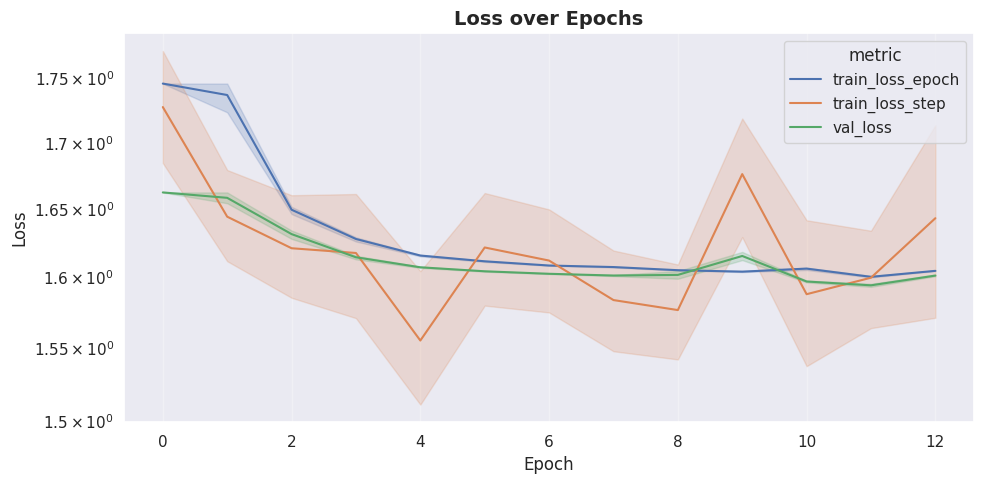

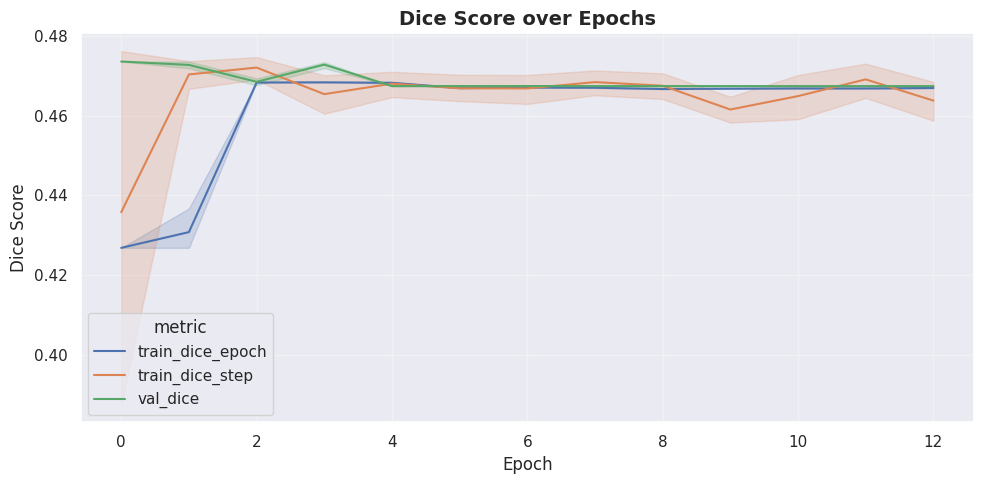

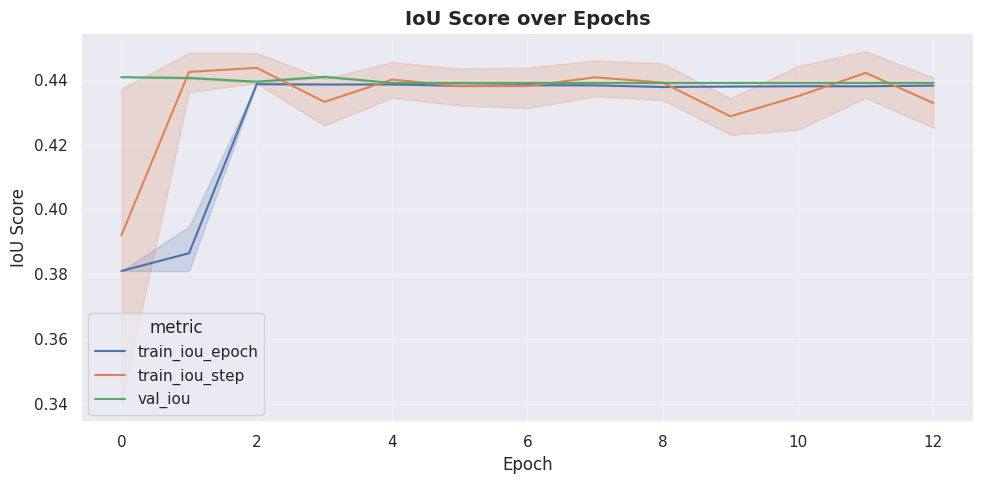

In [15]:
import seaborn as sns
from IPython.display import display # Ensure display is available
sns.set()

# Read the metrics.csv using the trainer's logger directory
# We need to find the latest version directory within the logger's save_dir
log_base_dir = Path(trainer.logger.save_dir) / 'lightning_logs'

# Get the latest version directory
metrics_path = log_base_dir / f"version_{trainer.logger._version}" / 'metrics.csv'
print(f"Loading metrics from: {metrics_path}")

if metrics_path.exists():
    metrics = pd.read_csv(metrics_path)
    # Remove any columns that are entirely NaN (e.g., from different logging frequencies)
    display(metrics.dropna(axis=1, how="all").head())
    # Fill any NaN values by propagating the last valid observation forward (useful for sparse logging)
    metrics.ffill(inplace=True)
    # Melt the DataFrame to long-form for plotting
    # We assume 'epoch' is a reliable identifier for x-axis
    metrics_melted = metrics.reset_index().melt(
        id_vars='epoch', var_name='metric', value_name='value')
    # Define metric groups based on available metrics from VesuviusSegmentationModel
    metric_groups = {
        'Loss': [c for c in metrics.columns if '_loss' in c],
        'Dice Score': [c for c in metrics.columns if '_dice' in c],
        'IoU Score': [c for c in metrics.columns if '_iou' in c],
    }
    # Plot metrics for each group in a separate chart
    for title, metric_list in metric_groups.items():
        # Filter melted DataFrame for the current group
        group_metrics = metrics_melted[metrics_melted['metric'].isin(metric_list)]
        plt.figure(figsize=(10, 5))
        sns.lineplot(data=group_metrics, x='epoch', y='value', hue='metric')
        plt.title(f'{title} over Epochs', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel(title, fontsize=12)
        plt.grid(True, alpha=0.3)
        # Apply log scale only for Loss, not for Dice/IoU which are typically 0-1
        if title == 'Loss':
            plt.yscale('log')
        plt.tight_layout()
    plt.show()

## 🔮 Inference

In [16]:
# Get test dataset directly
test_dataset = datamodule.test_dataset
test_files = sorted([f.name for f in TEST_IMAGES_DIR.glob("*.tif")])
print(f"Test files: {test_files}")
test_dataset = SurfaceDataset3D(
    images_dir=TEST_IMAGES_DIR,
    labels_dir=None,
    volume_files=test_files,
    volume_shape=datamodule.volume_shape
)

Test files: ['1407735.tif']
Indexing volumes...
Found 1 volumes.


In [17]:
# Load best model
best_checkpoint_path, _ = get_best_checkpoint(
    [OUTPUT_DIR, CHECKPOINT_DIR], name=net_name)

assert best_checkpoint_path, "No checkpoint found in trainer, using current model state."
print(f"Loading best checkpoint: {best_checkpoint_path}")
# We must pass the 'net' argument because it was ignored in save_hyperparameters
model = SurfaceSegmentation3D.load_from_checkpoint(best_checkpoint_path, net=net)

model.eval()
model.to(DEVICE)

Found 3 checkpoints.
Best  (Score=0.4737): SegResNet-epoch=02-val_dice=0.4737.ckpt
Loading best checkpoint: SegResNet-epoch=02-val_dice=0.4737.ckpt


SurfaceSegmentation3D(
  (net_module): SegResNet(
    (act_mod): ReLU(inplace=True)
    (convInit): Convolution(
      (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    )
    (down_layers): ModuleList(
      (0): Sequential(
        (0): Identity()
        (1): ResBlock(
          (norm1): GroupNorm(8, 16, eps=1e-05, affine=True)
          (norm2): GroupNorm(8, 16, eps=1e-05, affine=True)
          (act): ReLU(inplace=True)
          (conv1): Convolution(
            (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          )
          (conv2): Convolution(
            (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          )
        )
      )
      (1): Sequential(
        (0): Convolution(
          (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
        )
        (1): ResBlock(
          (norm1)

In [18]:
from skimage.morphology import remove_small_objects, ball
import torch.nn.functional as F

def get_spherical_kernel(radius):
    """Generates a spherical kernel (structuring element) for 3D morphological operations."""
    # Generate boolean ball on CPU
    kernel_np = ball(radius)
    # Convert to float tensor: (1, 1, D, H, W)
    kernel = torch.from_numpy(kernel_np.astype(np.float32)).unsqueeze(0).unsqueeze(0)
    return kernel

def post_process_3d(
    volume: np.ndarray,
    min_size: int = 1000,
    closing_radius: int = 5,
    device: str = DEVICE,
) -> np.ndarray:
    """Applies 3D morphological operations to clean up a segmentation volume using a spherical element.

    Steps:
    1. Performs morphological closing (Dilation -> Erosion) with a spherical kernel.
    2. Removes small connected components.
    """
    # Ensure input is boolean
    binary_vol = volume > 0
    clean_vol_np = binary_vol

    # 1. Close gaps with Spherical Element (GPU accelerated)
    if closing_radius > 0:
        # print(f"Closing gaps with spherical radius {closing_radius} (GPU accelerated)...")
        # Prepare Input: (1, 1, D, H, W)
        input_tensor = torch.from_numpy(clean_vol_np.astype(np.float32)).unsqueeze(0).unsqueeze(0).to(device)
        # Prepare Kernel
        kernel = get_spherical_kernel(closing_radius).to(device)
        # Dilation: (Input * Kernel) > 0
        # We use padding=closing_radius to maintain the same spatial dimensions (same as 'same' padding)
        dilated = (F.conv3d(input_tensor, kernel, padding=closing_radius) > 0).float()
        # Erosion: 1 - ((1 - Dilated) * Kernel > 0)
        # This relies on the duality: Erosion(A) = ~Dilation(~A)
        eroded = 1.0 - (F.conv3d(1.0 - dilated, kernel, padding=closing_radius) > 0).float()
        # Retrieve result
        clean_vol_np = eroded.squeeze().cpu().numpy().astype(bool)

    # 2. Remove small objects (CPU-bound)
    # print(f"Removing small objects < {min_size} voxels (CPU-bound)...")
    clean_vol_np = remove_small_objects(clean_vol_np, min_size=min_size)

    return clean_vol_np.astype(np.uint8)

In [19]:
predictions_tif = []

# Iterate directly over the dataset
for image, _, frag_id in tqdm(test_dataset, desc="Processing and saving 3D predictions"):
    # image is (C, D, H, W)

    # 1. Preprocess: Use val_image_augments for resizing
    # Move image to device for GPU transform
    image_on_device = image.to(model.device)

    # Apply the image-only validation transform (which contains resizing)
    processed_data = datamodule.val_image_augments({"image": image_on_device})
    # Add batch dimension: (1, C, D, H, W)
    inputs_resized = processed_data["image"].unsqueeze(0)

    # 2. Inference
    with torch.no_grad():
        # Construct batch tuple simulating a dataloader batch: (inputs, targets, [frag_id])
        frag_id_list = [frag_id]
        pred_dict = model.predict_step((inputs_resized, None, frag_id_list), 0)
        # Get predicted class directly (already argmaxed in model)
        # (D, H, W) relative to MODEL_INPUT_SIZE
        pred_class = pred_dict["prediction"][0]

    # 3. Postprocess: Resize back to Original Shape
    # Get original shape from file directly
    image_path = test_dataset.images_dir / f"{frag_id}.tif"
    with tifffile.TiffFile(str(image_path)) as tif:
        original_shape = tif.series[0].shape # (D, H, W)
    # Prediction is binary class index (0 or 1). Convert to float for interpolation.
    pred_binary = pred_class.float()
    # Resize to original 3D dimensions using Nearest Neighbor to preserve binary labels
    # F.interpolate expects (B, C, D, H, W)
    pred_input_tensor = pred_binary.unsqueeze(0).unsqueeze(0)
    pred_restored = F.interpolate(
        pred_input_tensor,
        size=original_shape,
        mode='nearest'
    ).squeeze(0).squeeze(0) # Back to (D, H, W)
    # Convert to uint8 (0, 1)
    pred_saved = pred_restored.byte().cpu().numpy()
    # pred_saved = post_process_3d(pred_saved, min_size=20*20*35)

    # Save to TIFF
    prediction_tif_name = f"{frag_id}.tif"
    save_path = OUTPUT_DIR / prediction_tif_name
    tifffile.imwrite(str(save_path), pred_saved)
    predictions_tif.append(prediction_tif_name)
    # print(f"  {frag_id}: saved {save_path} with shape {pred_saved.shape}")

Processing and saving 3D predictions:   0%|          | 0/1 [00:00<?, ?it/s]

Visualizing cuts for: 1407735.tif


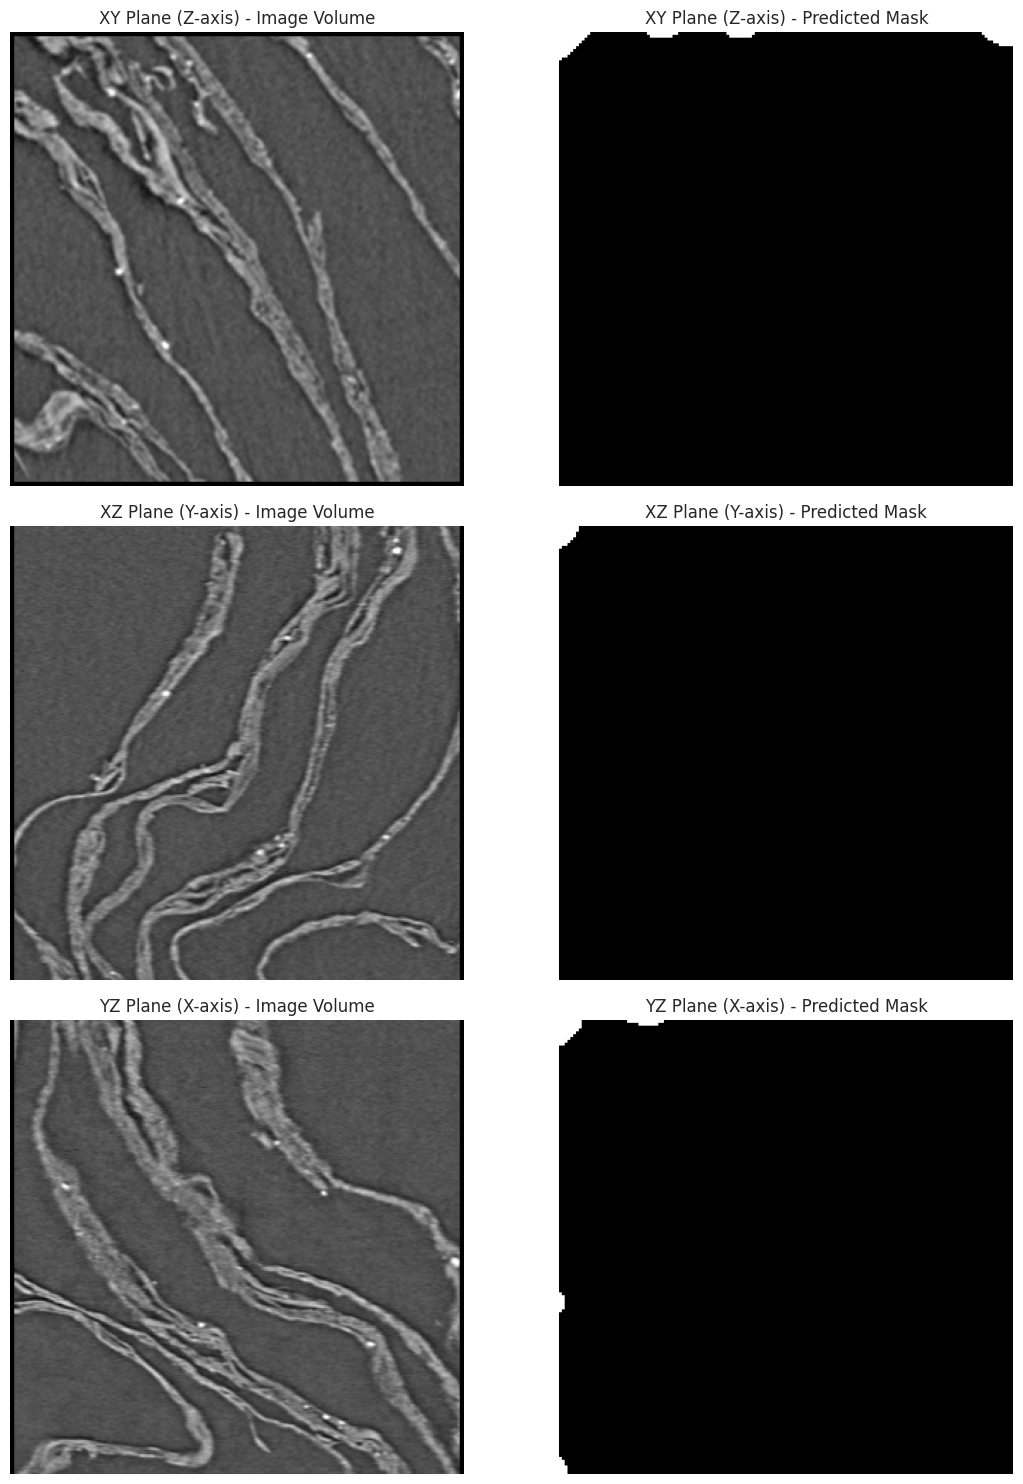

In [20]:
def plot_three_axis_cuts(image_vol_path, mask_vol_path):
    """Plots the middle slice of the XY, XZ, and YZ planes for both the image volume and the predicted mask."""
    print(f"Visualizing cuts for: {os.path.basename(image_vol_path)}")
    # Load volumes
    image_vol = tifffile.imread(image_vol_path)
    mask_vol = tifffile.imread(mask_vol_path)
    
    # Get dimensions
    d, h, w = image_vol.shape
    z_mid, y_mid, x_mid = d // 2, h // 2, w // 2
    
    # Extract slices
    slices = {
        'XY Plane (Z-axis)': (image_vol[z_mid, :, :], mask_vol[z_mid, :, :]),
        'XZ Plane (Y-axis)': (image_vol[:, y_mid, :], mask_vol[:, y_mid, :]),
        'YZ Plane (X-axis)': (image_vol[:, :, x_mid], mask_vol[:, :, x_mid])
    }
    
    fig, axes = plt.subplots(3, 2, figsize=(12, 15))
    for i, (plane_name, (img_slice, mask_slice)) in enumerate(slices.items()):
        # Image Volume
        axes[i, 0].imshow(img_slice, cmap='gray')
        axes[i, 0].set_title(f"{plane_name} - Image Volume")
        axes[i, 0].axis('off')
        
        # Mask
        axes[i, 1].imshow(mask_slice, cmap='gray')
        axes[i, 1].set_title(f"{plane_name} - Predicted Mask")
        axes[i, 1].axis('off')
        
    plt.tight_layout()
    plt.show()

# Visualize the first processed volume
if predictions_tif:
    mask_path = predictions_tif[0]
    name = os.path.basename(mask_path)
    image_path = os.path.join(TEST_IMAGES_DIR, name)
    plot_three_axis_cuts(image_path, mask_path)

In [21]:
import zipfile

print(f"Zipping {len(predictions_tif)} files...")
with zipfile.ZipFile('submission.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    for filename in tqdm(predictions_tif, desc="Zipping files"):
        if not os.path.exists(filename):
            print(f"Missing <> {filename}")
            continue
        # Write to zip
        zipf.write(filename)
        # Remove original file to save space
        os.remove(filename)

print("Submission.zip created successfully.")

Zipping 1 files...


Zipping files:   0%|          | 0/1 [00:00<?, ?it/s]

Submission.zip created successfully.
